# Title : Finding similarity between 2 sentences using KL divergence
### KL Divergence
Given 2 data distributions or probability distributions, KL divergence is used in finding how much distribution 1 differs from distribution 2. <br>
It is calculated using the below formula,<br>
- KL(p,q) = sum(p(x_i) * log(p(x_i)/q(x_i)))<br>

Here we have used spacy and nltk libraries to preprocess the sentences and create a data distribution. Then we applied the KL divergence on the 2 distributions of the sentences

### Properties of KL divergence
- It does not say about the distance between 2 distributions
- KL(P,Q) ≠ KL(Q,P)
- The KL(P,Q) is defined only when at any x, p(x) exists and ≠ 0


## Importing necessary libraries

In [1659]:
import spacy
from collections import Counter
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from pprint import pprint

In [1660]:
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sameeraholysheikabdullah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sameeraholysheikabdullah/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sameeraholysheikabdullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/sameeraholysheikabdullah/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [1661]:
nlp = spacy.load("en_core_web_sm")

## Removing StopWords
Stopwords are commonly used words in english like is, a, the, an, with, by, ........

In [1662]:
def remove_stop_words(sentence,pos):
    new_text = [(nlp(sentence)[i],pos[i][1]) for i in range(len(nlp(sentence))) if not nlp(sentence)[i].is_stop]
    return new_text


## Tokenising the words and mapping the POS Tags
POS tags are the parts of speech tag
* Example: I like cats \
In this sentence,\
I -> Noun\
like -> Verb\
cats -> Noun

## Lemmatisation 
It involves finding the root of a given word \
Example: Lemma of "caring" is "care"

In [1663]:
def apply_lemmatization(sentence):
    pos_tags_list = {
        "NOUN": "n",
        "VERB": "v",
        "ADJ" : "a",
        "ADV" : "r"
    }
    
    new_text = [(word[0].lemma_,pos_tags_list[word[1]]) for word in sentence]
    return new_text

## Finding similar words
This finds similar words in 2 sentences using synsets. \
Example: hello and greetings\
These two are different words but they are connected and have the same meaning

In [1664]:
def most_similar(word):
    w = word[0]
    pos = word[1]
    
    syn1 = wn.synsets(w,pos=pos)
    synset = [x.name().split('.')[0] for x in syn1]
    
    hypernym = [x.name().split('.')[0] for x in syn1[0].hypernyms()]
    synset.extend(hypernym)
    
    if pos=='n':
        syn2 = wn.synsets(w,pos='v')
        synset2 = [x.name().split('.')[0] for x in syn2]
        synset.extend(synset2)
    
    synset = [text for text in synset if text!=w]
    
    return list(set(synset))

In [1665]:
def check_similarity(s1, s2):
    similardict = {}
    
    unique_words = []
    for w in s1:
        if w not in unique_words:
            unique_words.append(w)
            
    for w in s2:
        if w not in unique_words:
            unique_words.append(w)
            
    for i in range(len(s1)):
        word = s1[i]
        
        if word not in s2:
            similar_words = most_similar(word)
            
            for word1 in s2:
                similar_words1 = most_similar(word1)
                match = list(set(similar_words).intersection(similar_words1))
                
                if len(match)>0:
                    s1[i] = word1
                    similardict[word]=word1
    
    return s1, s2, similardict

## Finding count of words
Given the word, this function finds how many times the same word appears in the sentence \
all_tokens = sentence1 + sentence2 \
This forms the total vocabulary for this given 2 sentences

In [1666]:
def combine_tokens(t1, t2):
    all_tokens_count = dict(Counter(t1+t2))
    print("The count of all words in 2 texts: \n",all_tokens_count)
    
    t1_count = dict(zip(all_tokens_count.keys(),[0]*len(all_tokens_count)))
    t2_count = dict(zip(all_tokens_count.keys(),[0]*len(all_tokens_count)))
    
    all_tokens = []
    for w in t1:
        if w not in all_tokens:
            all_tokens.append(w)
        t1_count[w] += 1
            
    for w in t2:
        if w not in all_tokens:
            all_tokens.append(w)
        t2_count[w] += 1
    
    print("\nThe unique words are: \n",all_tokens)
    
    return all_tokens, all_tokens_count, t1_count, t2_count

## Finding distribution
This returns distribution of the each word in the whole sentence

In [1667]:
def create_distribution(sentence,all_tokens,name):
    dist = dict(zip(all_tokens,[0]*len(all_tokens)))
    
    for word in sentence:
        dist[word]+=1
    
    for key in dist:
        dist[key]/=len(sentence)
    
    print("The word distribution for ",name," is: \n",dist,"\n")
    print(sentence)
    return dist

## Laplace Smoothing
We are applying Laplace Smoothing because given a word in a vocabulary, it is possible that it is not present in the given sentence. This leads to a value of zero in its distribution. But KL Divergence is defined only for distribution which is not equal to zero.\
Hence it is important to apply Laplace smoothing. It returns a value for a X instead of 0\
Here we are choosing alpha=0.05. Because if it is 1, it increases the likelihood of it present in the sentence

In [1668]:
def laplace_smoothing(count,tokens_count,alpha=0.05):
    distribution={}
    
    lenCorpus=0
    for word,p in count.items():
        if p!=0:
            lenCorpus+=1
    
    for word,p in count.items():    
        distribution[word] = (count[word] + alpha)/(lenCorpus + len(tokens_count)*alpha)
    
    return distribution

## Calculating KL Divergence
Given 2 distributions, it returns a value greater than 0 which defines how close 2 sentences are.

In [1669]:
def KLDivergence(dist1,dist2):
    val=0
    
    dist1 = list(dist1)
    dist2 = list(dist2)
    
    for i in range(len(dist1)):
        val += dist1[i] * np.log(dist1[i]/dist2[i])
        
    return val

## Plot Distribution

In [1670]:
def plot_distribution(x1, y1, x2, y2, xlab, ylab, title1, title2):
    plt.figure(figsize=(15,4))
    
    plt.subplot(1,2,1)
    plt.bar(x1,y1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title1)
    
    plt.subplot(1,2,2)
    plt.bar(x2,y2)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title2)

## Call all the above functions

In [1671]:
def calcKLD(sent1, sent2):
    print("*"*30," Tokenising and POS(Parts of Speech) Tagging ","*"*30,"\n")
    pos1 = nltk.pos_tag(word_tokenize(sent1.lower()),tagset='universal')
    pos2 = nltk.pos_tag(word_tokenize(sent2.lower()),tagset='universal')
    print("Sentence 1:")
    pprint(pos1)
    print("\nSentence 2:")
    pprint(pos2)
    
    print("\n","*"*20," Removing StopWords(a, the, ...) and (Adjectives, Adverbs) ","*"*20,"\n")
    without_stop_words1 = remove_stop_words(sent1,pos1)
    lemma_tokens1 = apply_lemmatization(without_stop_words1)
    print("Sentence 1: ",lemma_tokens1)
    
    without_stop_words2 = remove_stop_words(sent2,pos2)
    lemma_tokens2 = apply_lemmatization(without_stop_words2)
    print("Sentence 2: ",lemma_tokens2)
    
    
    s1,s2,dictio = check_similarity(lemma_tokens1,lemma_tokens2)

    print("\n","*"*30," Finding Similar Words between sentences if any ","*"*30,"\n")
    if len(dictio)>0:
        print("Found similar words")
    else:
        print("No similar words found") 
        
    pprint(dictio)
    print()
        
    all_tokens, all_tokens_count, sent1_count, sent2_count = combine_tokens(s1,s2)
    
    print("\n","*"*30," Finding distribution of words ","*"*30,"\n")
    
    dist1 = create_distribution(lemma_tokens1,all_tokens,"text 1")
    dist2 = create_distribution(lemma_tokens2,all_tokens,"text 2")
    
    print("\n","*"*30," Applying Laplace-Smoothing for Unigram Words ","*"*30,"\n")
    if (0 in dist1.values()):
        dist1 = laplace_smoothing(sent1_count, all_tokens_count)
    print("Distribution for sentence 1:")
    pprint(dist1)
    
    if (0 in dist2.values()):
        dist2 = laplace_smoothing(sent2_count, all_tokens_count)
    print("\nDistribution for sentence 2:")
    pprint(dist2)
    
    
    return dist1, dist2

## Lets try with an example

In [1672]:
sent1 = "A man was chased by a dog"
sent2 = "A dog chased a man"
dist1, dist2 = calcKLD(sent1,sent2)

******************************  Tokenising and POS(Parts of Speech) Tagging  ****************************** 

Sentence 1:
[('a', 'DET'),
 ('man', 'NOUN'),
 ('was', 'VERB'),
 ('chased', 'VERB'),
 ('by', 'ADP'),
 ('a', 'DET'),
 ('dog', 'NOUN')]

Sentence 2:
[('a', 'DET'),
 ('dog', 'NOUN'),
 ('chased', 'VERB'),
 ('a', 'DET'),
 ('man', 'NOUN')]

 ********************  Removing StopWords(a, the, ...) and (Adjectives, Adverbs)  ******************** 

Sentence 1:  [('man', 'n'), ('chase', 'v'), ('dog', 'n')]
Sentence 2:  [('dog', 'n'), ('chase', 'v'), ('man', 'n')]

 ******************************  Finding Similar Words between sentences if any  ****************************** 

No similar words found
{}

The count of all words in 2 texts: 
 {('man', 'n'): 2, ('chase', 'v'): 2, ('dog', 'n'): 2}

The unique words are: 
 [('man', 'n'), ('chase', 'v'), ('dog', 'n')]

 ******************************  Finding distribution of words  ****************************** 

The word distribution for  text 1 

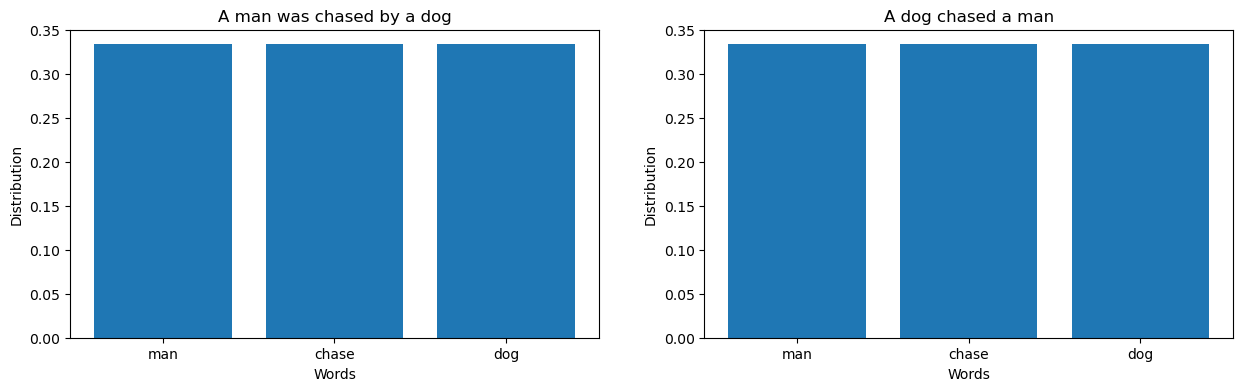

In [1673]:
x1=[str(i[0]) for i in dist1.keys()]
y1=np.array(list(dist1.values()))

x2=[str(i[0]) for i in dist2.keys()]
y2=np.array(list(dist2.values()))

plot_distribution(x1,y1,x2,y2,"Words","Distribution",sent1,sent2)


kl = KLDivergence(dist1.values(), dist2.values())
kl_reverse = KLDivergence(dist2.values(), dist1.values())

## We can see here that 2 sentences are having the same meaning and KLD is 0.0 as expected

In [1674]:
print("\n","*"*30," Finding KL Divergence ","*"*30,"\n")
print("Sentence 1: ",sent1)
print("Sentence 2: ",sent2)
print("\nKL Divergence", kl)
print("\nKL Divergence Reverse", kl_reverse)


 ******************************  Finding KL Divergence  ****************************** 

Sentence 1:  A man was chased by a dog
Sentence 2:  A dog chased a man

KL Divergence 0.0

KL Divergence Reverse 0.0


## Here is the second example

### Here "like" and "wish" almost have some shared meaning. Lets check this

In [1682]:
sent1 = "I like cats and dogs"
sent2 = "I wish I have a cat"
dist1, dist2 = calcKLD(sent1,sent2)

******************************  Tokenising and POS(Parts of Speech) Tagging  ****************************** 

Sentence 1:
[('i', 'NOUN'),
 ('like', 'VERB'),
 ('cats', 'NOUN'),
 ('and', 'CONJ'),
 ('dogs', 'NOUN')]

Sentence 2:
[('i', 'ADJ'),
 ('wish', 'VERB'),
 ('i', 'NOUN'),
 ('have', 'VERB'),
 ('a', 'DET'),
 ('cat', 'NOUN')]

 ********************  Removing StopWords(a, the, ...) and (Adjectives, Adverbs)  ******************** 

Sentence 1:  [('like', 'v'), ('cat', 'n'), ('dog', 'n')]
Sentence 2:  [('wish', 'v'), ('cat', 'n')]

 ******************************  Finding Similar Words between sentences if any  ****************************** 

Found similar words
{('like', 'v'): ('wish', 'v')}

The count of all words in 2 texts: 
 {('wish', 'v'): 2, ('cat', 'n'): 2, ('dog', 'n'): 1}

The unique words are: 
 [('wish', 'v'), ('cat', 'n'), ('dog', 'n')]

 ******************************  Finding distribution of words  ****************************** 

The word distribution for  text 1  is: 
 {

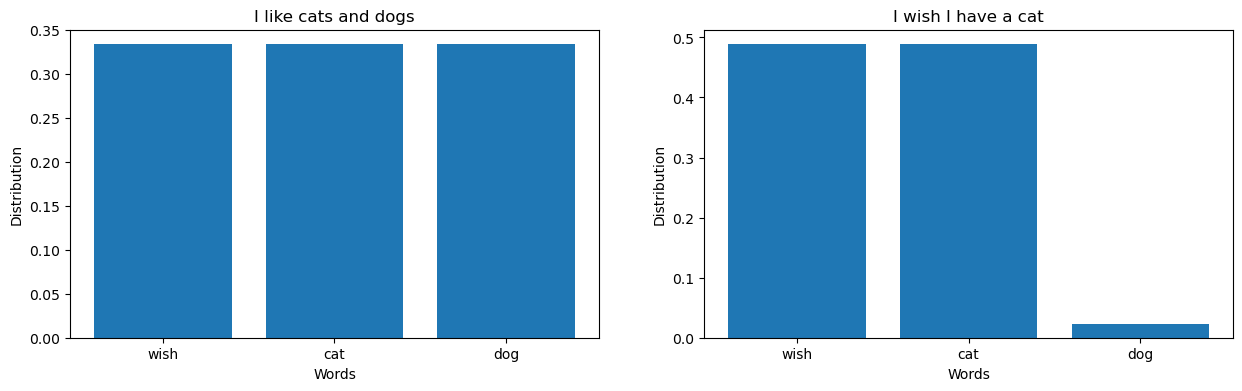

In [1676]:
x1=[str(i[0]) for i in dist1.keys()]
y1=np.array(list(dist1.values()))

x2=[str(i[0]) for i in dist2.keys()]
y2=np.array(list(dist2.values()))

plot_distribution(x1,y1,x2,y2,"Words","Distribution",sent1,sent2)

kl = KLDivergence(dist1.values(), dist2.values())
kl_reverse = KLDivergence(dist2.values(), dist1.values())

## The KL is not zero. But it is close to zero. As expected, they have the same meaning

In [1677]:
print("\n","*"*30," Finding KL Divergence ","*"*30,"\n")
print("Sentence 1: ",sent1)
print("Sentence 2: ",sent2)
print("\nKL Divergence", kl)
print("\nKL Divergence Reverse", kl_reverse)


 ******************************  Finding KL Divergence  ****************************** 

Sentence 1:  I like cats and dogs
Sentence 2:  I wish I have a cat

KL Divergence 0.6329062018765038

KL Divergence Reverse 0.31113176330905357


## Here is the third example

In [1678]:
sent1 = "Malls are great places to shop I can find everything I need under one roof"
sent2 = "Should we start class now or should we wait for everyone to get here"
dist1, dist2 = calcKLD(sent1,sent2)

******************************  Tokenising and POS(Parts of Speech) Tagging  ****************************** 

Sentence 1:
[('malls', 'NOUN'),
 ('are', 'VERB'),
 ('great', 'ADJ'),
 ('places', 'NOUN'),
 ('to', 'PRT'),
 ('shop', 'VERB'),
 ('i', 'NOUN'),
 ('can', 'VERB'),
 ('find', 'VERB'),
 ('everything', 'NOUN'),
 ('i', 'NOUN'),
 ('need', 'VERB'),
 ('under', 'ADP'),
 ('one', 'NUM'),
 ('roof', 'NOUN')]

Sentence 2:
[('should', 'VERB'),
 ('we', 'PRON'),
 ('start', 'VERB'),
 ('class', 'NOUN'),
 ('now', 'ADV'),
 ('or', 'CONJ'),
 ('should', 'VERB'),
 ('we', 'PRON'),
 ('wait', 'VERB'),
 ('for', 'ADP'),
 ('everyone', 'NOUN'),
 ('to', 'PRT'),
 ('get', 'VERB'),
 ('here', 'ADV')]

 ********************  Removing StopWords(a, the, ...) and (Adjectives, Adverbs)  ******************** 

Sentence 1:  [('mall', 'n'), ('great', 'a'), ('place', 'n'), ('shop', 'v'), ('find', 'v'), ('need', 'v'), ('roof', 'n')]
Sentence 2:  [('start', 'v'), ('class', 'n'), ('wait', 'v')]

 ******************************  F

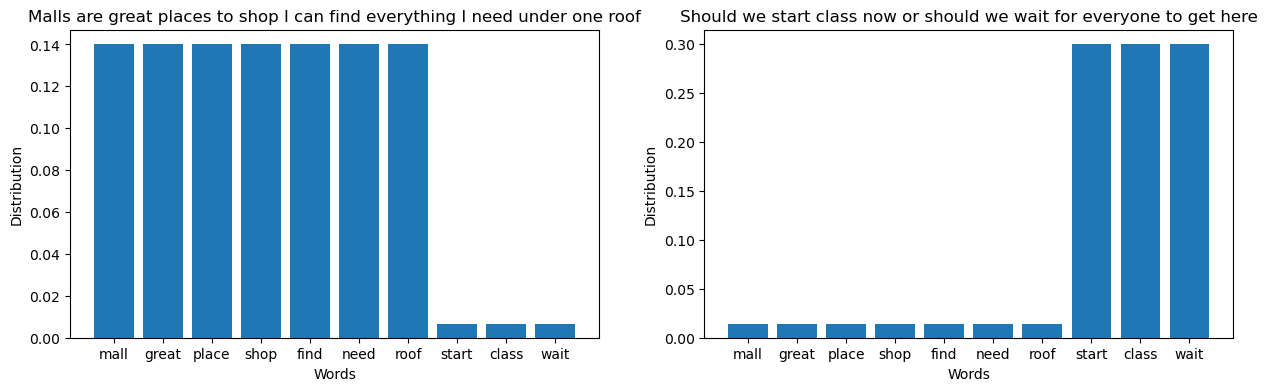

In [1679]:
x1=[str(i[0]) for i in dist1.keys()]
y1=np.array(list(dist1.values()))

x2=[str(i[0]) for i in dist2.keys()]
y2=np.array(list(dist2.values()))

plot_distribution(x1,y1,x2,y2,"Words","Distribution",sent1,sent2)

kl = KLDivergence(dist1.values(), dist2.values())
kl_reverse = KLDivergence(dist2.values(), dist1.values())

## The KL is high, therefore the 2 distributions are not the same

In [1680]:
print("\n","*"*30," Finding KL Divergence ","*"*30,"\n")
print("Sentence 1: ",sent1)
print("Sentence 2: ",sent2)
print("\nKL Divergence", kl)
print("\nKL Divergence Reverse", kl_reverse)


 ******************************  Finding KL Divergence  ****************************** 

Sentence 1:  Malls are great places to shop I can find everything I need under one roof
Sentence 2:  Should we start class now or should we wait for everyone to get here

KL Divergence 2.1606014881675892

KL Divergence Reverse 3.197758002225635
